Problem Statement

An education company named X Education sells online courses to industry professionals. The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Now, although X Education gets a lot of leads, its lead conversion rate is very poor. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers.

Libraries

In [166]:
import pandas as pd
pd.set_option('display.max_colwidth', None) #to display full text in df'S
import numpy as np
import scipy as sc
from openpyxl import Workbook
from ipywidgets import interactive
import ipywidgets as widgets
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
from scipy import stats
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor


Pipeline

Results from the analysis below

In [4]:
## Data cleaning /handling NaNs / bucketing /handling outliers


def clean_data(df):
    df.columns=[e.lower().replace(' ', '_') for e in df.columns] #all columns in lower case and with _
    
    # 'select' is a placehholder and needs to be treated like NaN
    df.replace('Select', np.NaN, inplace =True)
    
    #dropping cloumns with > 30% nulls
    #missing_value_df = df.isnull()
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_data_30 = list(missing_value_df[missing_value_df['percent_missing']>30]['column_name'])
    df.drop(columns=missing_data_30, inplace= True)
    
    # replacement with median to deal with the ouliers
    df['totalvisits'].fillna(df['totalvisits'].median(),inplace=True)
    df['page_views_per_visit'].fillna(df['page_views_per_visit'].median(),inplace=True)
    
    #using the most frequent method to fill values
    df.last_activity.replace(np.NaN, 'Email Opened', inplace =True)
    df.lead_source.replace(np.NaN, 'Google', inplace =True)
    
    #bucketing marked spam as unsubscribed
    df.lead_source.replace('Email Marked Spam','Unsubscribed', inplace = True)
    df.last_notable_activity.replace('Email Marked Spam','Unsubscribed', inplace = True)
    
    #bucketing values < 30 to 'Other'
    df.last_activity.replace(('Approached upfront','View in browser link Clicked','Email Received','Email Marked Spam','Visited Booth in Tradeshow','Resubscribed to emails'), 'Other', inplace = True)
    df.lead_source.replace(('bing','google','blog','Payoer Click Ads','Social Media','WeLearn','Click2call','Live Chat','welearnblog_Home','youtubechannel','testone','Press_Release','NC_EDM', 'Pay per Click Ads'), 'Other', inplace = True)
    df.last_notable_activity.replace(('Had a Phone Conversation','Approached upfront','Resubscribed to emails','View in browser link Clicked','Form Submitted on Website','Email Received'), 'Other', inplace = True)
    # bucket buisnessman and working professional 
    df.what_is_your_current_occupation.replace('Businessman', 'Working Professional', inplace =True)
    #bucketing add forms
    df.lead_origin.replace(('Quick Add Form','Lead Add Form'),'Add Form', inplace =True)
    #bucketing email bounced and unreachable
    df.last_notable_activity.replace('Email Bounced','Unreachable', inplace = True)
    
    # as NaN can be seen equal to other (not known), I will replace NaN's with 'Other' in occupation
    df.what_is_your_current_occupation.replace(np.NaN, 'Other', inplace =True)
    df.what_matters_most_to_you_in_choosing_a_course.replace(np.NaN, 'Other', inplace =True)
    
    
    #drop column which is just for identification
    df.drop(columns = 'prospect_id', inplace =True)
    
    
    #drop columns which have no or little variance
    df.drop(columns = 'country', inplace =True) #A/B testing
    df.drop(columns = 'search', inplace =True) #A/B testing
    df.drop(columns = 'what_matters_most_to_you_in_choosing_a_course', inplace =True)
    df.drop(columns = 'magazine', inplace =True)
    df.drop(columns = 'newspaper_article', inplace =True)
    df.drop(columns = 'x_education_forums', inplace =True)
    df.drop(columns = 'newspaper', inplace =True)
    df.drop(columns = 'digital_advertisement', inplace =True)
    df.drop(columns = 'through_recommendations', inplace =True)
    df.drop(columns = 'receive_more_updates_about_our_courses', inplace =True)
    df.drop(columns = 'get_updates_on_dm_content', inplace =True)
    df.drop(columns = 'i_agree_to_pay_the_amount_through_cheque', inplace =True)
    df.drop(columns = 'update_me_on_supply_chain_content', inplace = True)
    df.drop(columns = 'do_not_call', inplace = True)
    
    #treating outliers with z scorre > 3
    z = np.abs(stats.zscore(df.page_views_per_visit))
    threshold = 5
    outliers_pagevisits =(np.where(z > 3))
    outliers_pagevisits = np.array(outliers_pagevisits).tolist()
    z1 = np.abs(stats.zscore(df.totalvisits))
    threshold = 5
    outliers_totalvisits =(np.where(z1 > 3))
    outliers_totalvisits = np.array(outliers_totalvisits).tolist()
    #combine both lists to the drop these rows
    outliers = [*outliers_totalvisits, *outliers_pagevisits]
    for i in outliers:
        df.drop(df.index[[i]], inplace = True)
    #df.drop(columns = 'lead_number', inplace =True) #--> will use it later to give the score based on this number
    
    
    #display(df.isnull().sum())
    return df
    

Load Dataset

In [81]:
## Kaggle dataset into df
lead_df = pd.read_csv('files/Lead Scoring.csv')
lead_df.columns=[e.lower().replace(' ', '_') for e in lead_df.columns] #all columns in lower case and with _

In [ ]:
Checking the Conversion Rate

In [190]:
print("The current conversion rate from X Education is ", round((sum(lead_df['converted'])/len(lead_df['converted'].index))*100), "%")

The current conversion rate from X Education is  39 %


Check & handle Null Values

In [82]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   prospect_id                                    9240 non-null   object 
 1   lead_number                                    9240 non-null   int64  
 2   lead_origin                                    9240 non-null   object 
 3   lead_source                                    9204 non-null   object 
 4   do_not_email                                   9240 non-null   object 
 5   do_not_call                                    9240 non-null   object 
 6   converted                                      9240 non-null   int64  
 7   totalvisits                                    9103 non-null   float64
 8   total_time_spent_on_website                    9240 non-null   int64  
 9   page_views_per_visit                           9103 

In [83]:
metadata = pd.read_excel('files/Leads Data Dictionary.xlsx')
#metadata= metadata.drop(metadata.index[:2])
metadata= metadata.drop(columns ='Unnamed: 0').rename(columns={'Unnamed: 1': 'Column', 'Unnamed: 2': 'Describtion'}).drop(metadata.index[:2]).reset_index().drop(columns='index')
metadata

,Column,Describtion
0,Prospect ID,A unique ID with which the customer is identified.
1,Lead Number,A lead number assigned to each lead procured.
2,Lead Origin,"The origin identifier with which the customer was identified to be a lead. Includes API, Landing Page Submission, etc."
3,Lead Source,"The source of the lead. Includes Google, Organic Search, Olark Chat, etc."
4,Do Not Email,An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.
5,Do Not Call,An indicator variable selected by the customer wherein they select whether of not they want to be called about the course or not.
6,Converted,The target variable. Indicates whether a lead has been successfully converted or not.
7,TotalVisits,The total number of visits made by the customer on the website.
8,Total Time Spent on Website,The total time spent by the customer on the website.
9,Page Views Per Visit,Average number of pages on the website viewed during the visits.


Duplicates /Missing Values

In [84]:
#check & delete duplicates
display(lead_df.shape)
lead_df= lead_df.drop_duplicates()
lead_df.shape

(9240, 37)

(9240, 37)

In [85]:
#check &delete empty rows
display(lead_df.shape)
lead_df =lead_df.dropna(how ='all')
lead_df.shape

(9240, 37)

(9240, 37)

In [86]:
lead_df.isnull().sum()

prospect_id                                         0
lead_number                                         0
lead_origin                                         0
lead_source                                        36
do_not_email                                        0
do_not_call                                         0
converted                                           0
totalvisits                                       137
total_time_spent_on_website                         0
page_views_per_visit                              137
last_activity                                     103
country                                          2461
specialization                                   1438
how_did_you_hear_about_x_education               2207
what_is_your_current_occupation                  2690
what_matters_most_to_you_in_choosing_a_course    2709
search                                              0
magazine                                            0
newspaper_article           

In [87]:
#get columns with more than 30% missing values (assumption these columns shouldn't be filled with means/medians)
missing_value_df = lead_df.isnull()
#get % of missing values
percent_missing = lead_df.isnull().sum() * 100 / len(lead_df)
missing_value_df = pd.DataFrame({'column_name': lead_df.columns,
                                 'percent_missing': percent_missing})


missing_data_30 = list(missing_value_df[missing_value_df['percent_missing']>30]['column_name'])
len(missing_data_30), missing_data_30


(6,
 ['tags',
  'lead_quality',
  'asymmetrique_activity_index',
  'asymmetrique_profile_index',
  'asymmetrique_activity_score',
  'asymmetrique_profile_score'])

In [88]:
# dropping columns with more than 30& missing valueslead
print('Originally the dataset had', len(lead_df.columns), 'columns')
lead_df.drop(columns=missing_data_30, inplace= True)
print('Now the dataset has', len(lead_df.columns), 'columns')


Originally the dataset had 37 columns
Now the dataset has 31 columns


Deal with missing data < 30 %

In [89]:
missing_value_df = lead_df.isnull()
#get % of missing values
percent_missing = lead_df.isnull().sum() * 100 / len(lead_df)
missing_value_df = pd.DataFrame({'column_name': lead_df.columns,
                                 'percent_missing': percent_missing})


missing_data = list(missing_value_df[missing_value_df['percent_missing']!=0]['column_name'])
len(missing_data), missing_data

(11,
 ['lead_source',
  'totalvisits',
  'page_views_per_visit',
  'last_activity',
  'country',
  'specialization',
  'how_did_you_hear_about_x_education',
  'what_is_your_current_occupation',
  'what_matters_most_to_you_in_choosing_a_course',
  'lead_profile',
  'city'])

Total visits

False    9103
True      137
Name: totalvisits, dtype: int64

<AxesSubplot:xlabel='totalvisits'>

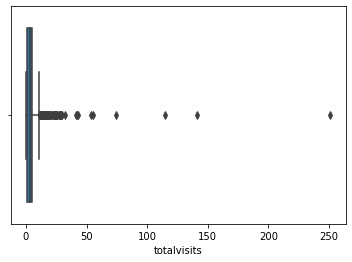

In [90]:
display(lead_df.totalvisits.isnull().value_counts())
#check for outliers
sns.boxplot(lead_df.totalvisits)

In [91]:
# replacement with median to deal with the ouliers ->will later remove outliers
lead_df['totalvisits'].fillna(lead_df['totalvisits'].median(),inplace=True)
lead_df['totalvisits'].isnull().sum()

0

page_views_per_visit

False    9103
True      137
Name: page_views_per_visit, dtype: int64

<AxesSubplot:xlabel='page_views_per_visit'>

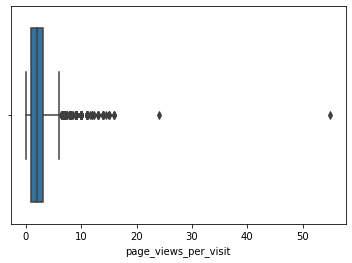

In [92]:
display(lead_df.page_views_per_visit.isnull().value_counts())
#check for outliers
sns.boxplot(lead_df.page_views_per_visit)

In [93]:
# replacement with median to deal with the ouliers
lead_df['page_views_per_visit'].fillna(lead_df['page_views_per_visit'].median(),inplace=True)
lead_df['page_views_per_visit'].isnull().sum()

0

last_activity

In [94]:
display(lead_df.last_activity.isnull().value_counts())
#check values
lead_df.last_activity.value_counts()

False    9137
True      103
Name: last_activity, dtype: int64

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: last_activity, dtype: int64

In [95]:
#using the most frequent method to fill values
lead_df.last_activity.replace(np.NaN, 'Email Opened', inplace =True)

display(lead_df.last_activity.isnull().value_counts())
lead_df.last_activity.value_counts()

False    9240
Name: last_activity, dtype: int64

Email Opened                    3540
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: last_activity, dtype: int64

In [96]:
#bucketing values < 30 to 'Other'
lead_df.last_activity.replace(('Approached upfront','View in browser link Clicked','Email Received','Email Marked Spam','Visited Booth in Tradeshow','Resubscribed to emails'), 'Other', inplace = True)



country

In [97]:
display(lead_df.country.isnull().value_counts())
#check unique values
lead_df.country.value_counts()
# problem: no variation (most values from india)
#probably will drop the column

False    6779
True     2461
Name: country, dtype: int64

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malaysia      

specialization

In [98]:
display(lead_df.specialization.isnull().value_counts())
#check unique values
lead_df.specialization.value_counts()

False    7802
True     1438
Name: specialization, dtype: int64

Select                               1942
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: specialization, dtype: int64

In [99]:
#checking df for more select values
lead_df[lead_df == 'Select'].count()

prospect_id                                         0
lead_number                                         0
lead_origin                                         0
lead_source                                         0
do_not_email                                        0
do_not_call                                         0
converted                                           0
totalvisits                                         0
total_time_spent_on_website                         0
page_views_per_visit                                0
last_activity                                       0
country                                             0
specialization                                   1942
how_did_you_hear_about_x_education               5043
what_is_your_current_occupation                     0
what_matters_most_to_you_in_choosing_a_course       0
search                                              0
magazine                                            0
newspaper_article           

In [100]:
#checking df for  select values
lead_df[lead_df == 'Select'].count()
# select seems to be a placeholder - will treat it as null value --> will be included in Pipeline
lead_df.replace('Select', np.NaN, inplace =True)
# will be dropped as it has now more than 30% missing values


what_is_your_current_occupation

In [101]:
display(lead_df.what_is_your_current_occupation.isnull().sum())
lead_df.what_is_your_current_occupation.value_counts()


2690

Unemployed              5600
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: what_is_your_current_occupation, dtype: int64

In [102]:
# as NaN can be seen equal to other (not known), I will replace NaN's with 'Other'
lead_df.what_is_your_current_occupation.replace(np.NaN, 'Other', inplace =True)

# buisnessman and working professional are similar, so i will bucket it together
lead_df.what_is_your_current_occupation.replace('Businessman', 'Working Professional', inplace =True)
lead_df.what_is_your_current_occupation.value_counts()

Unemployed              5600
Other                   2706
Working Professional     714
Student                  210
Housewife                 10
Name: what_is_your_current_occupation, dtype: int64

what_matters_most_to_you_in_choosing_a_course

In [103]:
display(lead_df.what_matters_most_to_you_in_choosing_a_course.isnull().sum())
lead_df.what_matters_most_to_you_in_choosing_a_course.value_counts()

2709

Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: what_matters_most_to_you_in_choosing_a_course, dtype: int64

In [104]:
# as NaN can be seen equal to other (not known), I will replace NaN's with 'Other'
lead_df.what_matters_most_to_you_in_choosing_a_course.replace(np.NaN, 'Other', inplace =True)
lead_df.what_matters_most_to_you_in_choosing_a_course.value_counts()

Better Career Prospects      6528
Other                        2710
Flexibility & Convenience       2
Name: what_matters_most_to_you_in_choosing_a_course, dtype: int64

Better Career Prospects      6528
Other                        2710
Flexibility & Convenience       2
Name: what_matters_most_to_you_in_choosing_a_course, dtype: int64

<AxesSubplot:xlabel='count', ylabel='what_matters_most_to_you_in_choosing_a_course'>

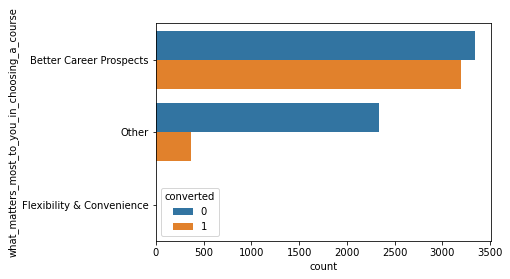

In [105]:
display(lead_df.what_matters_most_to_you_in_choosing_a_course.value_counts())
sns.countplot( y=lead_df.what_matters_most_to_you_in_choosing_a_course, hue = lead_df.converted)

# no high variance / importance for analysing what makes people to convert or not --> will drop column

lead_source

In [106]:
display(lead_df.lead_source.isnull().sum())
lead_df.lead_source.value_counts()

36

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: lead_source, dtype: int64

In [107]:
#using the most frequent method to fill values
lead_df.lead_source.replace(np.NaN, 'Google', inplace =True)

display(lead_df.lead_source.isnull().value_counts())
lead_df.lead_source.value_counts()

False    9240
Name: lead_source, dtype: int64

Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: lead_source, dtype: int64

In [108]:
#bucketing spam as unsubscribed
lead_df.lead_source.replace('Email Marked Spam','Unsubscribed', inplace = True)
#bucketing values < 30 to 'Other'
lead_df.lead_source.replace(('bing','google','blog','Payoer Click Ads','Social Media','WeLearn','Click2call','Live Chat','welearnblog_Home','youtubechannel','testone','Press_Release','NC_EDM','Pay per Click Ads' ), 'Other', inplace = True)

In [109]:
lead_df.lead_source.value_counts()

Google              2904
Direct Traffic      2543
Olark Chat          1755
Organic Search      1154
Reference            534
Welingak Website     142
Referral Sites       125
Facebook              55
Other                 28
Name: lead_source, dtype: int64

----------

Analysing remaining columns

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: lead_origin, dtype: int64

Landing Page Submission    4886
API                        3580
Add Form                    719
Lead Import                  55
Name: lead_origin, dtype: int64

<AxesSubplot:xlabel='count', ylabel='lead_origin'>

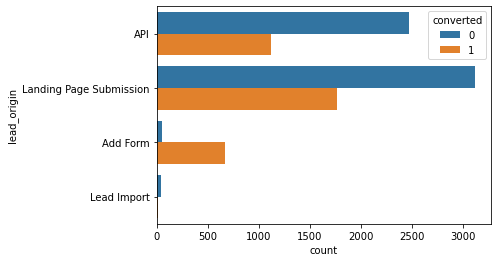

In [110]:
display(lead_df.lead_origin.value_counts())
#bucketing add forms together
lead_df.lead_origin.replace(('Quick Add Form','Lead Add Form'),'Add Form', inplace =True)
display(lead_df.lead_origin.value_counts())
sns.countplot( y=lead_df.lead_origin, hue = lead_df.converted)

#The conversion from the API and LP submission are really poor -> first recommendation to improve these channels

In [111]:
lead_df.do_not_email.value_counts()

No     8506
Yes     734
Name: do_not_email, dtype: int64

In [112]:
lead_df.do_not_call.value_counts()
#almost no variance will drop it

No     9238
Yes       2
Name: do_not_call, dtype: int64

In [113]:
lead_df.converted.value_counts() #will be the target variable 1= converted 0 = not converted

0    5679
1    3561
Name: converted, dtype: int64

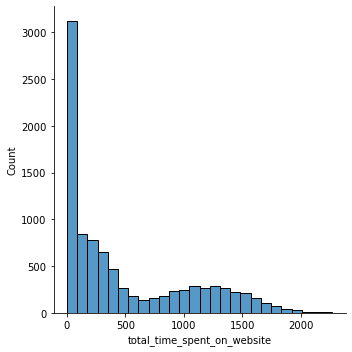

In [114]:
lead_df.total_time_spent_on_website.value_counts()
sns.displot(data=lead_df.total_time_spent_on_website)

In [115]:
lead_df.search.value_counts()
#not great variance, might be using it in B in a A/B testing

No     9226
Yes      14
Name: search, dtype: int64

In [116]:
lead_df.magazine.value_counts()
#just one value, no importance so will drop the column

No    9240
Name: magazine, dtype: int64

In [117]:
lead_df.newspaper_article.value_counts()
#again almost no variance, no importance so will drop the column

No     9238
Yes       2
Name: newspaper_article, dtype: int64

In [118]:
lead_df.x_education_forums.value_counts()
#again almost no variance, no importance so will drop the column

No     9239
Yes       1
Name: x_education_forums, dtype: int64

In [119]:
lead_df.update_me_on_supply_chain_content.value_counts()
#again no variance, no importance so will drop the column

No    9240
Name: update_me_on_supply_chain_content, dtype: int64

In [120]:
lead_df.newspaper.value_counts()
#again almost no variance, no importance so will drop the column

No     9239
Yes       1
Name: newspaper, dtype: int64

In [121]:
lead_df.digital_advertisement.value_counts()
#again almost no variance, no importance so will drop the column

No     9236
Yes       4
Name: digital_advertisement, dtype: int64

In [122]:
lead_df.through_recommendations.value_counts()
#again almost no variance, no importance so will drop the column

No     9233
Yes       7
Name: through_recommendations, dtype: int64

In [123]:
lead_df.receive_more_updates_about_our_courses.value_counts()
# no variance, no importance so will drop the column

No    9240
Name: receive_more_updates_about_our_courses, dtype: int64

In [124]:
lead_df.get_updates_on_dm_content.value_counts()
# no variance, no importance so will drop the column

No    9240
Name: get_updates_on_dm_content, dtype: int64

In [125]:
lead_df.i_agree_to_pay_the_amount_through_cheque.value_counts()
# no variance, no importance so will drop the column

No    9240
Name: i_agree_to_pay_the_amount_through_cheque, dtype: int64

No     6352
Yes    2888
Name: a_free_copy_of_mastering_the_interview, dtype: int64

<AxesSubplot:xlabel='count', ylabel='a_free_copy_of_mastering_the_interview'>

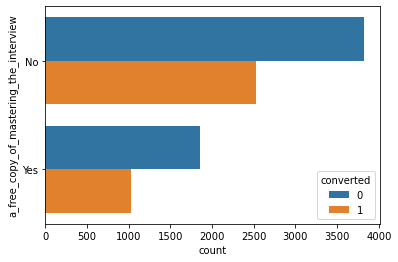

In [126]:
display(lead_df.a_free_copy_of_mastering_the_interview.value_counts())
sns.countplot( y=lead_df.a_free_copy_of_mastering_the_interview, hue = lead_df.converted)
#has apperantly no big influence on ppl to convert

In [127]:
display(lead_df.last_notable_activity.value_counts())
#bucketing unsubscribed and Email marked spam
lead_df.last_notable_activity.replace('Email Marked Spam','Unsubscribed', inplace = True)
#bucketing bounced and unrechable
lead_df.last_notable_activity.replace('Email Bounced','Unreachable', inplace = True)
#bucketing under 30 to other
lead_df.last_notable_activity.replace(('Had a Phone Conversation','Approached upfront','Resubscribed to emails','View in browser link Clicked','Form Submitted on Website','Email Received'), 'Other', inplace = True)
lead_df.last_notable_activity.value_counts()

Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: last_notable_activity, dtype: int64

Modified                   3407
Email Opened               2827
SMS Sent                   2172
Page Visited on Website     318
Olark Chat Conversation     183
Email Link Clicked          173
Unreachable                  92
Unsubscribed                 49
Other                        19
Name: last_notable_activity, dtype: int64

Check Outliers in numerical features

In [128]:
# getting numerical  values
lead_numerical = lead_df.select_dtypes(include=np.number)
#dropping lead number and converted(target variabble)
lead_numerical.drop(columns =(['lead_number', 'converted']),inplace = True)

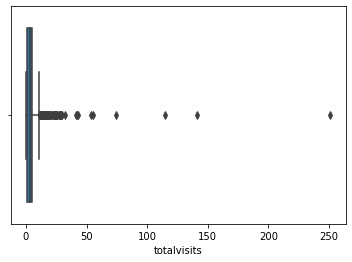

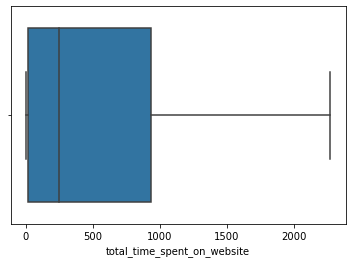

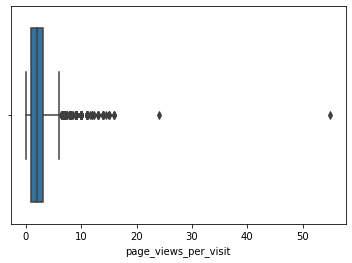

In [129]:
#total_visits
for i in lead_numerical:
    
    sns.boxplot(i, data =lead_numerical)
    plt.show()

Outliers detected in page_views_per_visit and totalvisits with z-score

A Z-score of zero represents a value that equals the mean. The further away an observation's Z-score is from zero, the more unusual it is. A standard cut-off value for finding outliers are Z-scores of +/-3 or further from zero.

In [130]:
z = np.abs(stats.zscore(lead_df.page_views_per_visit))
threshold = 5
outliers_pagevisits =(np.where(z > 3))
outliers_pagevisits = np.array(outliers_pagevisits).tolist()

z1 = np.abs(stats.zscore(lead_df.totalvisits))
threshold = 5
outliers_totalvisits =(np.where(z1 > 3))
outliers_totalvisits = np.array(outliers_totalvisits).tolist()

#combine both lists to the drop these rows
outliers = [*outliers_totalvisits, *outliers_pagevisits]
#outliers


In [131]:
a =lead_df.shape

In [132]:
for i in outliers:
    lead_df.drop(lead_df.index[[i]], inplace = True)

In [133]:
b= lead_df.shape
print("The original df shape was",a, ". After removing the outliers, the dataset shape is:",b,".", round(b[0] / a[0] *100), "% of the dataset rows will be used for the analysis!")


The original df shape was (9240, 31) . After removing the outliers, the dataset shape is: (9037, 31) . 98 % of the dataset rows will be used for the analysis!


In [327]:
#loading cleaned dataset
lead_df = pd.read_csv('files/Lead Scoring.csv')
clean_data(lead_df)

,lead_number,lead_origin,lead_source,do_not_email,converted,totalvisits,total_time_spent_on_website,page_views_per_visit,last_activity,what_is_your_current_occupation,a_free_copy_of_mastering_the_interview,last_notable_activity
0,660737,API,Olark Chat,No,0,0.000,0,0.000,Page Visited on Website,Unemployed,No,Modified
1,660728,API,Organic Search,No,0,5.000,674,2.500,Email Opened,Unemployed,No,Email Opened
2,660727,Landing Page Submission,Direct Traffic,No,1,2.000,1532,2.000,Email Opened,Student,Yes,Email Opened
3,660719,Landing Page Submission,Direct Traffic,No,0,1.000,305,1.000,Unreachable,Unemployed,No,Modified
4,660681,Landing Page Submission,Google,No,1,2.000,1428,1.000,Converted to Lead,Unemployed,No,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...
9235,579564,Landing Page Submission,Direct Traffic,Yes,1,8.000,1845,2.670,Other,Unemployed,No,Unsubscribed
9236,579546,Landing Page Submission,Direct Traffic,No,0,2.000,238,2.000,SMS Sent,Unemployed,Yes,SMS Sent
9237,579545,Landing Page Submission,Direct Traffic,Yes,0,2.000,199,2.000,SMS Sent,Unemployed,Yes,SMS Sent
9238,579538,Landing Page Submission,Google,No,1,3.000,499,3.000,SMS Sent,Other,No,SMS Sent


Checking Imbalance of dataset 

using the dependent variable ='converted' , now concrete cutoff when a dataset is considered imbalanced, however common is to consider it as imbalanced if the ratio is greater than 1:9

In [328]:
lead_df.converted.value_counts()
#dataset imbalance ratio is just 1: 1.6, so no down-or upsampling needed

0    5548
1    3489
Name: converted, dtype: int64

Data preprocessing

In [329]:
# numerical &categorical values
lead_numerical = lead_df.select_dtypes(include=np.number).drop(columns=['lead_number', 'converted'])
lead_categorical = lead_df.select_dtypes(include=np.object)
lead_categorical.shape

(9037, 7)

In [330]:
print(list(lead_numerical))
list(lead_categorical)


['totalvisits', 'total_time_spent_on_website', 'page_views_per_visit']


['lead_origin',
 'lead_source',
 'do_not_email',
 'last_activity',
 'what_is_your_current_occupation',
 'a_free_copy_of_mastering_the_interview',
 'last_notable_activity']

Checking for high correlation in numerical values

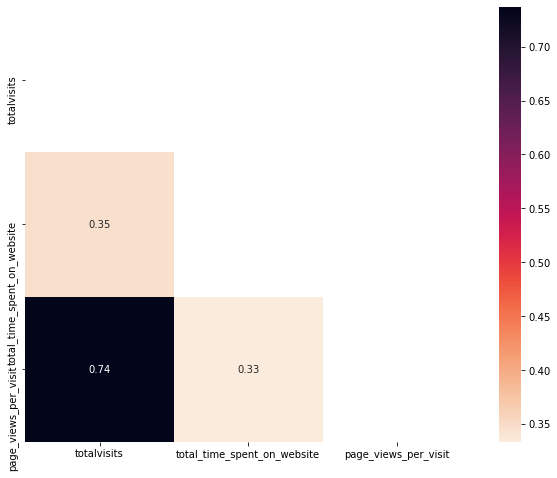

In [331]:
#correleation between numerical features
#Dropping features that show a high correlation between them (greater than 0.9)

correlations = lead_numerical.corr()
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(lead_numerical.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(lead_numerical.corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

#no high correlation

Encoding

In [332]:
#get dummies for categorical values
dummies = pd.get_dummies(data = lead_categorical, drop_first=True)
display(dummies.shape)


(9037, 36)

Scaling numerical features

*data normalization is not needed but also won’t affect the output for Tree/Random Forest classifiers

In [333]:

#scaling numerical features

scaler = StandardScaler()
scaler.fit(lead_numerical) #z score 
lead_numericals_scaled = scaler.transform(lead_numerical) #gives an array
lead_numericals_scaled = pd.DataFrame(lead_numericals_scaled, columns = lead_numerical.columns) #transform it to a df
display(lead_numerical.head(2))
print()
display(lead_numericals_scaled.head(2))

lead_numericals_scaled.shape


,totalvisits,total_time_spent_on_website,page_views_per_visit
0,0.000,0,0.000
1,5.000,674,2.500


,totalvisits,total_time_spent_on_website,page_views_per_visit
0,-1.082,-0.890,-1.149
1,0.609,0.340,0.088


(9037, 3)

Plotting categorical Features

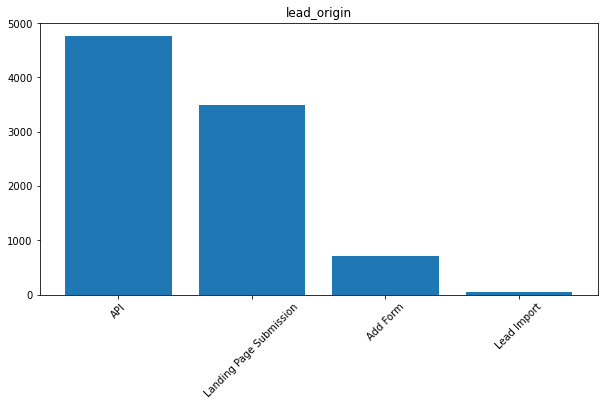

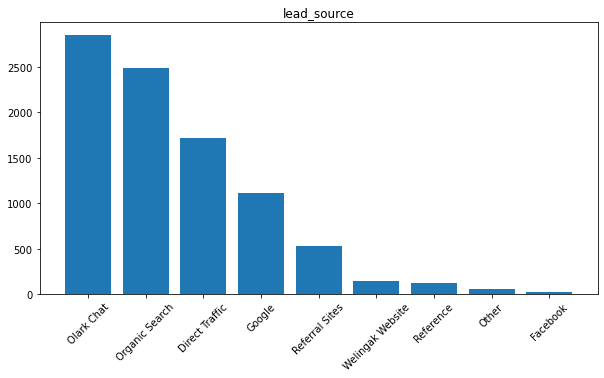

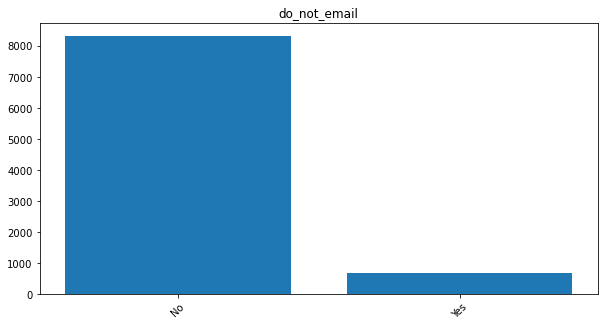

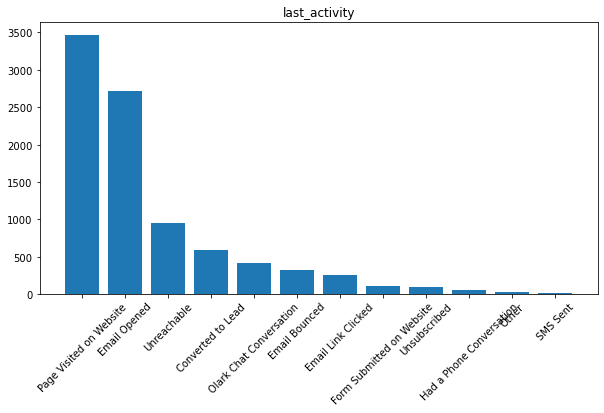

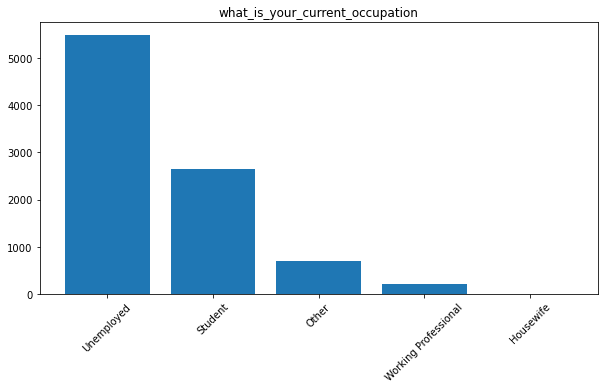

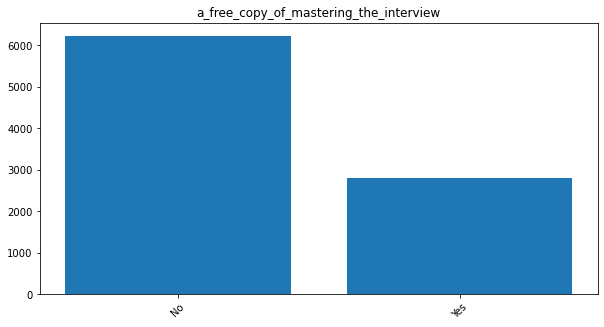

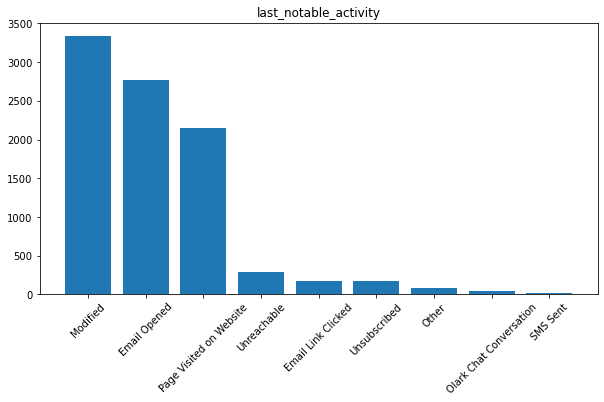

In [287]:
for c in lead_categorical:
    plt.figure(figsize=(10,5))
    plt.bar(lead_categorical[c].unique(), lead_categorical[c].value_counts())
    plt.title(c)
    plt.xticks(rotation=45)
    plt.show();

Plotting numerical Features

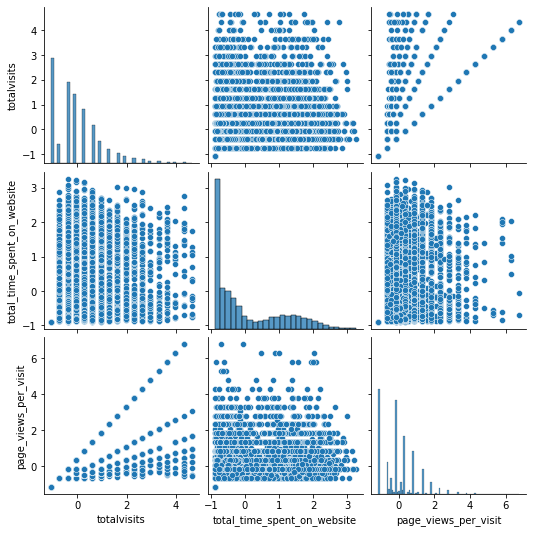

In [288]:
#Use seaborn library to construct distribution plots for the numerical_scaled variables##
sns.pairplot(lead_numericals_scaled)
plt.show()

Combining scaled numerical and encoded categorical data

In [334]:
#hstack scaled numerical & encoded categorical
lead_df_numbers = pd.DataFrame(np.hstack([dummies, lead_numericals_scaled]))

#saving column names in a list to append it
column_names = [*dummies.columns.tolist(),*lead_numericals_scaled.columns.tolist()]


lead_df_numbers.set_axis(column_names,axis =1,inplace=True)



Correlation for scaled and encoded dataset

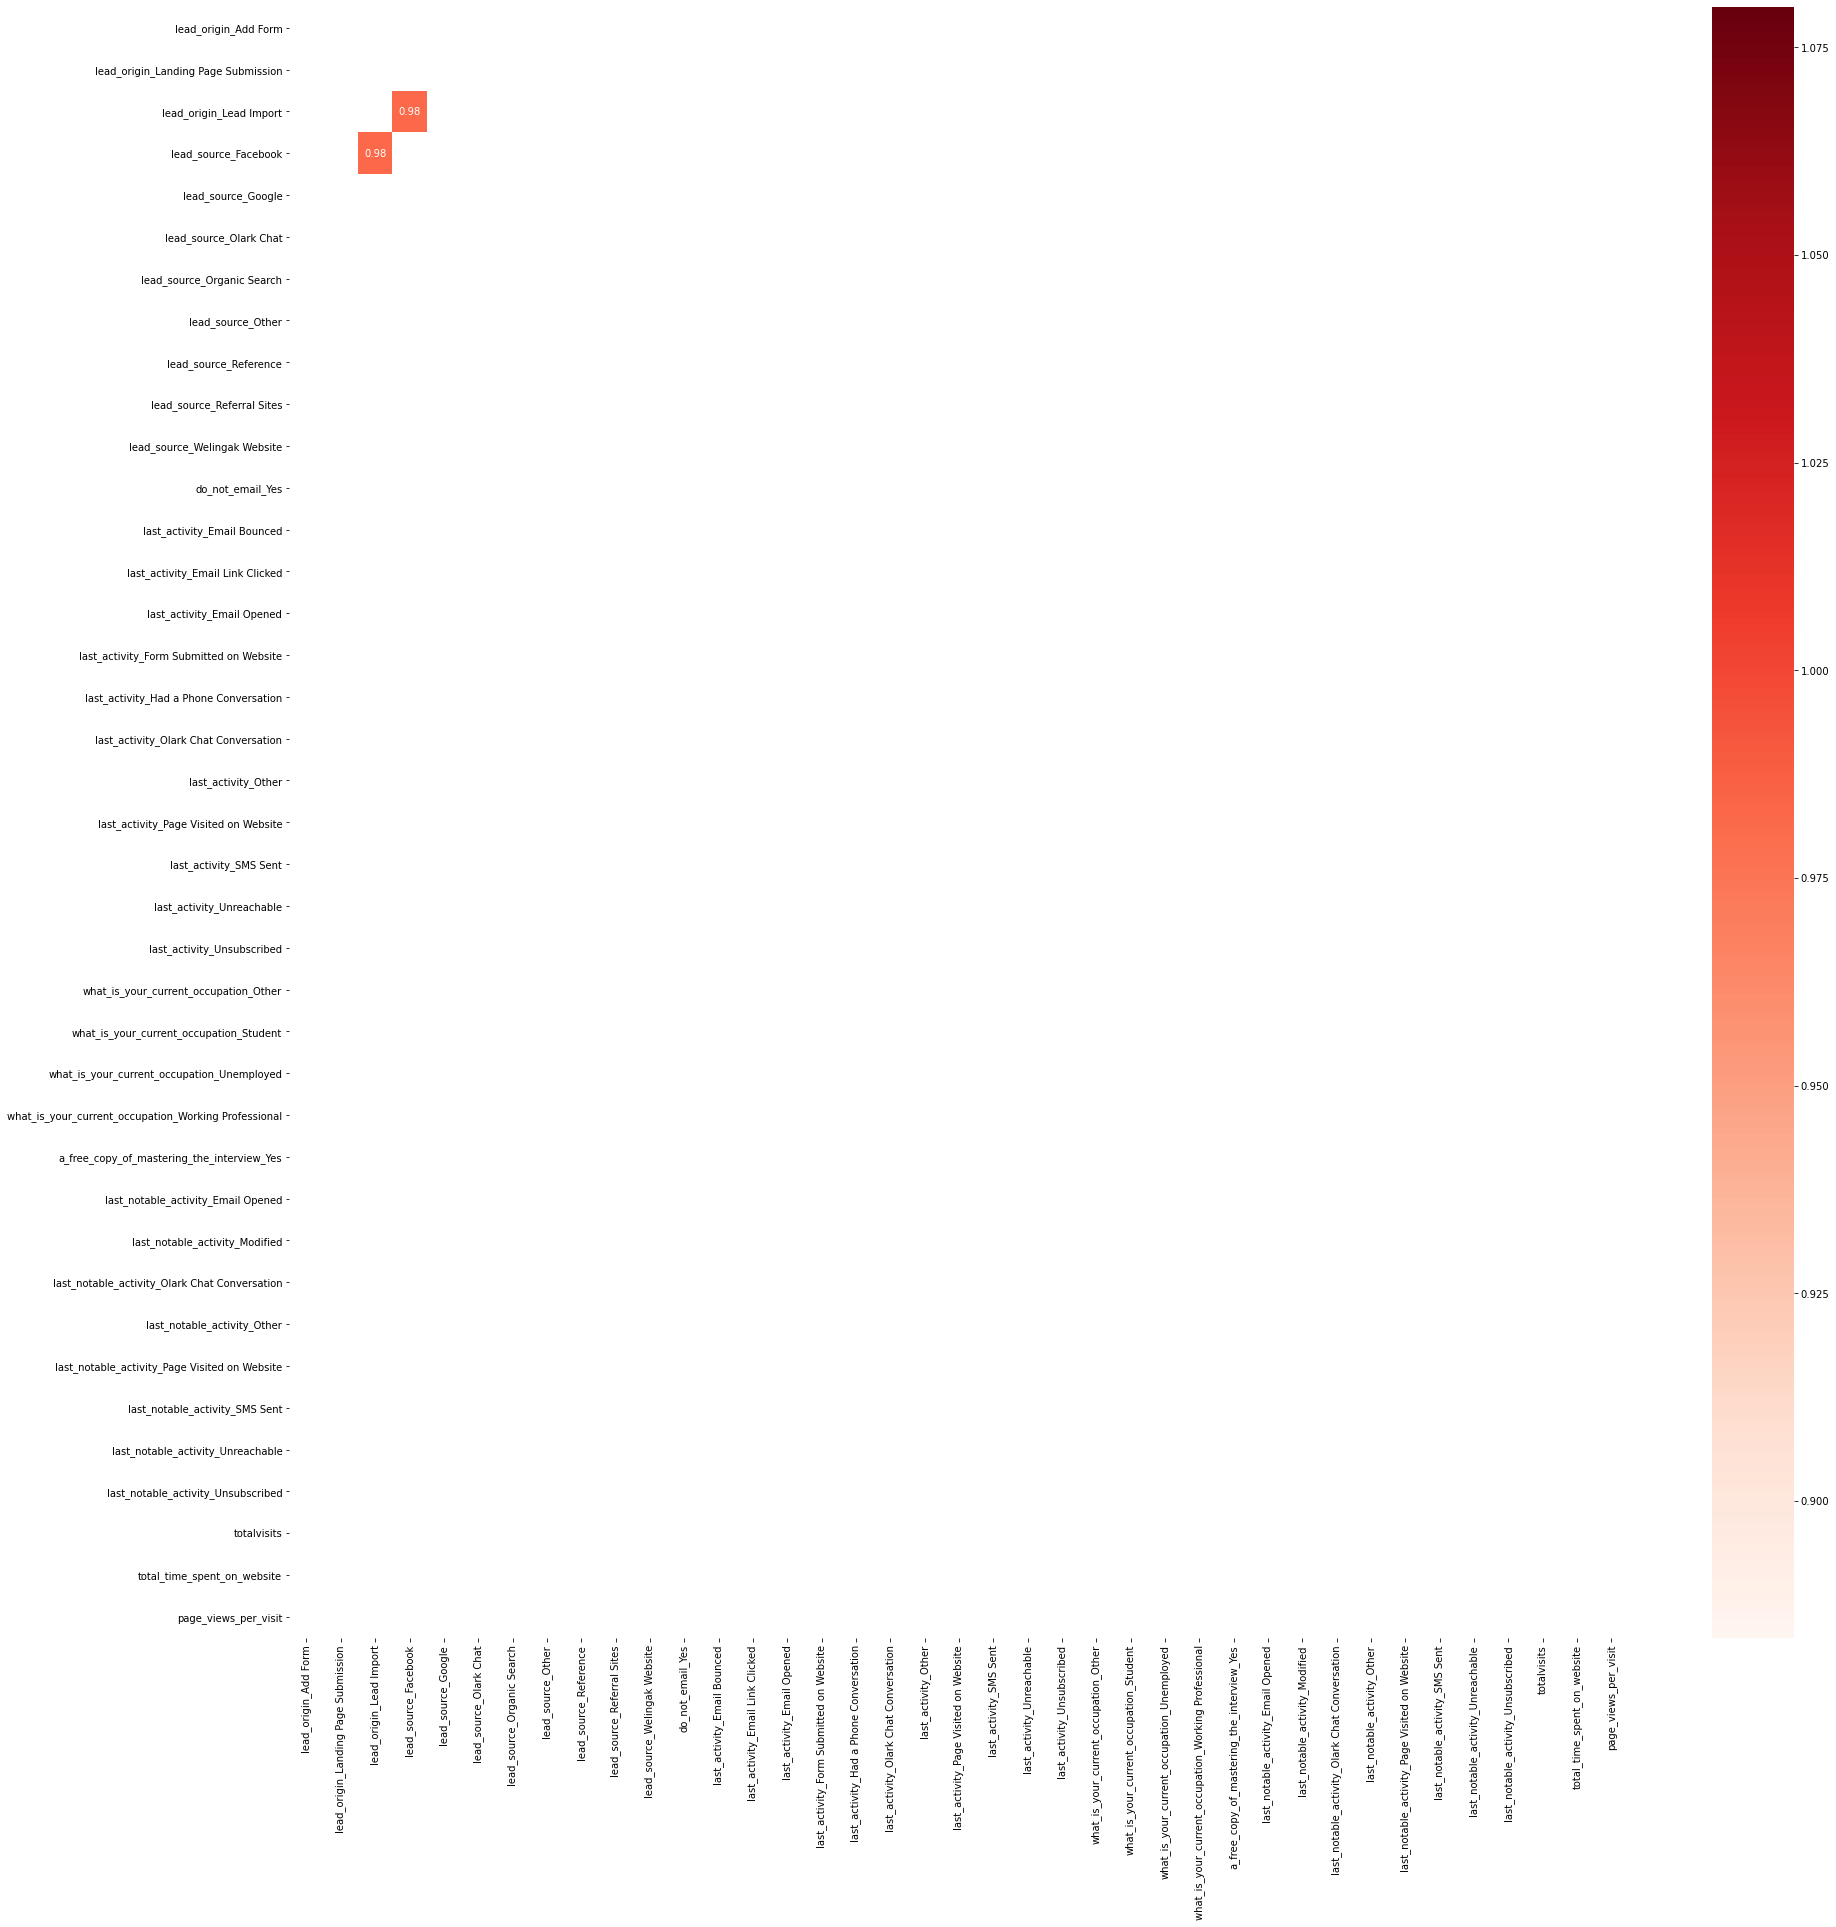

In [290]:
dfCorr = lead_df_numbers.corr()
filteredDf = dfCorr[((dfCorr >= .89) | (dfCorr <= -.89)) & (dfCorr !=1.000)] #just showing high correlation without duplicates (1)
plt.figure(figsize=(30,30))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

#lead_origin_Lead_import and lead_source_Facebook are highly correlated, will drop

In [335]:
#lead_origin_Lead_import and lead_source_Facebook are highly correlated
#dropping lead_source_Facebook
lead_df_numbers.drop(columns='lead_source_Facebook',inplace=True)

Setting the independent and dependent variable

In [336]:
X = lead_df_numbers
display(X.shape)
y = lead_df.converted
y = y.values.ravel() #y needs to be converted into a 1D for later modelling
y.shape


(9037, 38)

(9037,)

Testing Models

In [337]:

models = {
# Decision Trees
"Decision Tree Classifier":DecisionTreeClassifier(), 
# Naive Bayes
"GaussianNB": GaussianNB(),
# Support Vector Machines
"LinearSVC": LinearSVC(),
# Logistic Regression
"Logistic Regression": LogisticRegression(),
#Random Forest
"Random Forest": RandomForestClassifier()
            }

In [338]:
def eval_model(x,y,models):
    pd.options.display.float_format = "{:,.3f}".format #show three decimals in df
    accuracy, precision, recall = {}, {}, {}
    #enumerate attachs a number to the running output
    for (i, (name, model)) in enumerate (models.items()): #to access the models (name= key , model/items =values in dict)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state = 10)
        #model Training
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        
        #confusion matrix (not displaying it as it gets to much output)
        #try:
        #    print(name," Confusion matrix for the train set: ")
        #    print(confusion_matrix(y_train,y_pred_train))

        #    
        #    print(name, "Confusion matrix for the test set: ")
        #    print(confusion_matrix(y_test, y_pred))
        #    
        #except:
        #    print("confusion matrix is not available for this model: ", name)

        accuracy[name] = accuracy_score(y_pred, y_test)
        precision[name] = precision_score(y_pred, y_test)
        recall[name] = recall_score(y_pred, y_test)
        f1_score = 2*(( precision[name] * recall[name])/( precision[name] + recall[name]))
        #F1 score increases as the precision and recall value rises for a model.
        #A high score indicates that the model is well versed in terms of handling the class imbalance problem.
        print(name,"\nF1 score of the model: ",f1_score.round(3)) 
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
        print("Cross validation score: ",np.mean(cross_val_scores).round(3),"\n")


        
    df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
    df_model['Accuracy'] = accuracy.values()
    df_model['Precision'] = precision.values()
    df_model['Recall'] = recall.values()

    
    
    
    return df_model
        

In [339]:
eval_model(X,y,models)

Decision Tree Classifier 
F1 score of the model:  0.713
Cross validation score:  0.776 

GaussianNB 
F1 score of the model:  0.63
Cross validation score:  0.754 

LinearSVC 
F1 score of the model:  0.74
Cross validation score:  0.821 

Logistic Regression 
F1 score of the model:  0.741
Cross validation score:  0.822 

Random Forest 
F1 score of the model:  0.749
Cross validation score:  0.805 



,Accuracy,Precision,Recall
Decision Tree Classifier,0.771,0.744,0.684
GaussianNB,0.760,0.536,0.763
LinearSVC,0.811,0.707,0.777
Logistic Regression,0.812,0.706,0.779
Random Forest,0.808,0.749,0.749


Logistic Regression has overall the best results, therefore I will move forward with it for the feature importance selection

Statsmodel analysis of Logistic Regression

statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. 

In [340]:
# train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [341]:
# Logistic regression = Logit
logm1 = sm.Logit(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
result= logm1.fit()
result.summary()
    
## Logistic regression = Logit
#logm1 = sm.Logit(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
#logm1.fit().summary()

Optimization terminated successfully.
         Current function value: 0.390502
         Iterations 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6325
Model:                          Logit   Df Residuals:                     6286
Method:                           MLE   Df Model:                           38
Date:                Wed, 06 Oct 2021   Pseudo R-squ.:                  0.4130
Time:                        19:57:16   Log-Likelihood:                -2469.9
converged:                       True   LL-Null:                       -4207.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                 2.763e+04        nan        nan        nan         nan         nan
lead_origin_Add Form                                     3.1646      0.579      5.466      0.000       2.030       4.299
lead_origin_Landing Page Submission                     -0.2193      0.111     -1.977      0.048      -0.437      -0.002
lead_origin_Lead Import                                  0.1645      0.457      0.360      0.719      -0.732       1.061
lead_source_Google                                       0.2985      0.119      2.499      0.012       0.064       0.533
lead_source_Olark Chat                                   1.4076      0.168      8.364      0.000       1.078       1.737
lead_source_Organic Search                               0.1851      0.134      1.379      0.168      -0.078       0.448
lead_source_Other                                        0.5338      0.662      0.807      0.420      -0.763       1.831
lead_source_Reference                                    0.4886      0.617      0.792      0.429      -0.721       1.698
lead_source_Referral Sites                              -0.0514      0.375     -0.137      0.891      -0.786       0.683
lead_source_Welingak Website                             2.1802      0.926      2.354      0.019       0.365       3.995
do_not_email_Yes                                        -1.1694      0.216     -5.414      0.000      -1.593      -0.746
last_activity_Email Bounced                             -0.7727      0.490     -1.577      0.115      -1.733       0.188
last_activity_Email Link Clicked                         0.5282      0.419      1.261      0.207      -0.293       1.349
last_activity_Email Opened                               0.8194      0.245      3.341      0.001       0.339       1.300
last_activity_Form Submitted on Website                  0.4551      0.397      1.147      0.251      -0.323       1.233
last_activity_Had a Phone Conversation                   0.7011      0.891      0.787      0.431      -1.045       2.448
last_activity_Olark Chat Conversation                   -0.5244      0.279     -1.876      0.061      -1.072       0.023
last_activity_Other                                      0.9659      0.850      1.137      0.256      -0.699       2.631
last_activity_Page Visited on Website                    0.4685      0.297      1.580      0.114      -0.113       1.050
last_activity_SMS Sent                                   1.3150      0.249      5.290      0.000       0.828       1.802
last_activity_Unreachable                                0.6537      0.438      1.491      0.136      -0.205       1.513
last_activity_Unsubscribed                              -1.1824      2.111     -0.560      0.575      -5.320       2.956
what_is_your_current_occupation_Other                -2.764e+04        nan        nan        na

The p-Value: The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.

Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.

It is also important to avoid high correlation between the selected features. Using the VIF (Variance Inflation Factor) method this can be detected.

Note: Values of VIF that exceed 10 are often regarded as indicating multicollinearity, but in even values above 2.5 may be a cause for concern. 

In [322]:
def check_vif(X_train):
    vif = pd.DataFrame()
    vif['Features']=X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
    vif=vif.sort_values(by='VIF', ascending = False)
    vif['Ranking'] = range(len(vif), 0, -1)
    return vif


In [323]:
check_vif(X_train)

,Features,VIF,Ranking
24,what_is_your_current_occupation_Unemployed,98.222,38
28,last_notable_activity_Modified,51.341,37
22,what_is_your_current_occupation_Other,48.384,36
27,last_notable_activity_Email Opened,47.326,35
32,last_notable_activity_SMS Sent,37.739,34
0,lead_origin_Add Form,14.904,33
13,last_activity_Email Opened,14.290,32
25,what_is_your_current_occupation_Working Professional,13.622,31
7,lead_source_Reference,12.043,30
19,last_activity_SMS Sent,11.905,29


There are several columns with a VIF > 2.5 , for the next step of Feature selection, I will only consider 11 features (which have a VIF< 2.5)

Recursive feature elimination

RFE is a wrapper-type feature selection algorithm. In this case the model= LogisticRegression is used in the core of the method, is wrapped by RFE, and used to help select features. 

In [342]:
# Inputing 11 features selected for RFE
# We will then optimize the model further by inspecting VIF and p-value of the features

model = LogisticRegression()
selector = RFE(model, n_features_to_select=11, step = 1) # Step is how many features to add or drop everytime  
selector = selector.fit(X_train, y_train)

#list(zip(X_train.columns, rfe.support_, rfe.ranking_))


kept_features = selector.get_support(indices = True) 
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)


print("Final selected features: ")
display(X_train.head(2))
top_10 =pd.DataFrame()
top_10['Features']=(X_train.columns)
display(top_10)

cross_val_scores_new = cross_val_score(selector, X_train_ref, y_train_ref, cv=10)
print("Cross validation score: ",np.mean(cross_val_scores_new).round(3), ". Cross validation score with all features: 0.822")


Final selected features: 


,lead_origin_Add Form,lead_source_Olark Chat,lead_source_Welingak Website,last_activity_Email Bounced,last_activity_Olark Chat Conversation,what_is_your_current_occupation_Other,what_is_your_current_occupation_Working Professional,last_notable_activity_Other,last_notable_activity_SMS Sent,last_notable_activity_Unreachable,total_time_spent_on_website
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.045
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,-0.184


,Features
0,lead_origin_Add Form
1,lead_source_Olark Chat
2,lead_source_Welingak Website
3,last_activity_Email Bounced
4,last_activity_Olark Chat Conversation
5,what_is_your_current_occupation_Other
6,what_is_your_current_occupation_Working Professional
7,last_notable_activity_Other
8,last_notable_activity_SMS Sent
9,last_notable_activity_Unreachable


Cross validation score:  0.814 . Cross validation score with all features: 0.822


The cross validation score hasn't changed a lot, which shows that the selected variables can greatly explain the convertion.

Checking again the VIF of the selected features:

In [344]:
col = X_train.columns[rfe.support_] # saving selected columns

Statsmodels for the selected 11 features

In [346]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.Logit(y_train,X_train_sm, family = sm.families.Binomial())
result = logm2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.404446
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6325
Model:                          Logit   Df Residuals:                     6313
Method:                           MLE   Df Model:                           11
Date:                Wed, 06 Oct 2021   Pseudo R-squ.:                  0.3920
Time:                        20:03:31   Log-Likelihood:                -2558.1
converged:                       True   LL-Null:                       -4207.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.1739      0.054    -21.677      0.000      -1.280      -1.068
lead_origin_Add Form                                     3.6962      0.208     17.774      0.000       3.289       4.104
lead_source_Olark Chat                                   1.4643      0.108     13.569      0.000       1.253       1.676
lead_source_Welingak Website                             1.6762      0.748      2.242      0.025       0.211       3.142
last_activity_Email Bounced                             -2.6885      0.379     -7.103      0.000      -3.430      -1.947
last_activity_Olark Chat Conversation                   -1.3558      0.165     -8.218      0.000      -1.679      -1.032
what_is_your_current_occupation_Other                   -1.2309      0.090    -13.728      0.000      -1.407      -1.055
what_is_your_current_occupation_Working Professional     2.5491      0.188     13.559      0.000       2.181       2.918
last_notable_activity_Other                              2.5395      0.918      2.767      0.006       0.741       4.338
last_notable_activity_SMS Sent                           1.3471      0.080     16.899      0.000       1.191       1.503
last_notable_activity_Unreachable                        1.7550      0.430      4.082      0.000       0.912       2.598
total_time_spent_on_website                              1.1483      0.041     28.082      0.000       1.068       1.228
========================================================================================================================
"""

In [363]:
check_vif(X_train_sm)

,Features,VIF,Ranking
0,const,2.544,12
2,lead_source_Olark Chat,1.439,11
1,lead_origin_Add Form,1.389,10
5,last_activity_Olark Chat Conversation,1.288,9
11,total_time_spent_on_website,1.268,8
3,lead_source_Welingak Website,1.247,7
6,what_is_your_current_occupation_Other,1.153,6
4,last_activity_Email Bounced,1.140,5
10,last_notable_activity_Unreachable,1.120,4
9,last_notable_activity_SMS Sent,1.107,3


Selected Feature have no VIF > 2.5 and therefore a good selection for the lead scoring

Getting the Likelihood to convert on the train data

In [362]:

y_train_pred = result.predict(X_train_sm)
y_train_pred.max(), y_train_pred.min(), y_pred_train.mean() #reflect the liklihood calculated from the model that a lead will convert

(0.9994912637014542, 0.0022790844966511185, 0.3471936758893281)

In [360]:
conversion_80= [i for i in y_train_pred.value_counts() if i > 0.8]
print("There are",len(conversion_80), "leads in the train set that have a probability of converting higher than 80%.")


There are 3383 leads in the train set that have a probability of converting higher than 80%.


In [395]:
y_train_pred_df = pd.DataFrame()
y_train_pred_df['convertion_prob']=y_train_pred
y_train_pred_df['converted'] = y_train
y_train_pred_df['percentage'] =(y_train_pred* 100).round(1)
prob_80_df = y_train_pred_df[y_train_pred_df['convertion_prob']>0.8]
prob_80_df_not_converted = prob_80_df[prob_80_df['converted']==0]
prob_80_df_not_converted

,convertion_prob,converted,percentage
5,0.874,0,87.400
24,0.831,0,83.100
29,0.818,0,81.800
187,0.945,0,94.500
293,0.887,0,88.700
...,...,...,...
6172,0.960,0,96.000
6178,0.852,0,85.200
6179,0.846,0,84.600
6203,0.982,0,98.200


In [366]:
X_test_sm = sm.add_constant(X_test[col])
y_pred = result.predict(X_test_sm)
y_pred.max(), y_pred.min(), y_train.mean() #reflect the liklihood calculated from the model that a lead will convert

(0.9995262171520569, 0.0024113695456011793, 0.3824505928853755)

In [368]:
conversion_80_test= [i for i in y_pred.value_counts() if i > 0.8]
print("There are",len(conversion_80_test), "leads in the test set that have a probability of converting higher than 80%.")


There are 1729 leads in the test set that have a probability of converting higher than 80%.


In [396]:
y_pred_df = pd.DataFrame()
y_pred_df['convertion_prob']=y_pred
y_pred_df['converted'] = y_test
y_pred_df['percentage'] = (y_pred* 100).round(1)
prob_80_df_test = y_pred_df[y_pred_df['convertion_prob']>0.8]
prob_80_df_not_converted_test = prob_80_df[prob_80_df['converted']==0]
prob_80_df_not_converted_test

,convertion_prob,converted,percentage
5,0.874,0,87.400
24,0.831,0,83.100
29,0.818,0,81.800
187,0.945,0,94.500
293,0.887,0,88.700
...,...,...,...
6172,0.960,0,96.000
6178,0.852,0,85.200
6179,0.846,0,84.600
6203,0.982,0,98.200


Concating both train_test to display the overall likelihood to convert

In [397]:
Leadlist_focus = pd.concat([prob_80_df_not_converted, prob_80_df_not_converted_test], ignore_index=True)

In [398]:
Leadlist_focus

,convertion_prob,converted,percentage
0,0.874,0,87.400
1,0.831,0,83.100
2,0.818,0,81.800
3,0.945,0,94.500
4,0.887,0,88.700
...,...,...,...
247,0.960,0,96.000
248,0.852,0,85.200
249,0.846,0,84.600
250,0.982,0,98.200
